In [68]:
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import os
from google.cloud import storage

%load_ext google.cloud.bigquery

In [4]:
demoDf = pd.read_csv('./data/us_demography.csv')
demoDf.head()

,FIPS,State_FIP,State,StateName,County,Urban,Population,Frac65Plus,PopDensity
0,1001,1,AL,Alabama,Autauga County,2.0,55601,0.155627,93.534462
1,1003,1,AL,Alabama,Baldwin County,3.0,218022,0.204433,137.136021
2,1005,1,AL,Alabama,Barbour County,6.0,24881,0.194204,28.113870
3,1007,1,AL,Alabama,Bibb County,1.0,22400,0.164732,35.986190
4,1009,1,AL,Alabama,Blount County,1.0,57840,0.182365,89.697921


In [51]:
stateDemoDf = demoDf.copy()
stateDemoDf["elderlyPop"] = stateDemoDf[["Population", "Frac65Plus"]].apply(lambda x: x[0]*x[1], axis=1)
stateDemoDf["landArea"] = stateDemoDf[["Population", "PopDensity"]].apply(lambda x: x[0]/x[1], axis=1)
stateDemoDf = stateDemoDf.groupby(["State_FIP", "State", "StateName"]).agg({"Urban":"median",
                                                              "Population":"sum",
                                                              "elderlyPop":"sum",
                                                              "landArea":"sum"
                                                             }).reset_index()
stateDemoDf["Frac65Plus"] = stateDemoDf[["Population", "elderlyPop"]].apply(lambda x: x[1]/x[0], axis=1)
stateDemoDf["PopDensity"] = stateDemoDf[["Population", "landArea"]].apply(lambda x: x[0]/x[1], axis=1)
stateDemoDf.head()

,State_FIP,State,StateName,Urban,Population,elderlyPop,landArea,Frac65Plus,PopDensity
0,1,AL,Alabama,4.0,4887871,826894.0,50646.639,0.169173,96.509287
1,2,AK,Alaska,9.0,737438,87011.0,571016.948,0.117991,1.291447
2,4,AZ,Arizona,3.0,7171646,1258250.0,113653.146,0.175448,63.101166
3,5,AR,Arkansas,6.0,3013825,511827.0,52037.528,0.169826,57.916375
4,6,CA,California,2.5,39557045,5669025.0,155854.041,0.143313,253.808273


## Using Google Big Query to get cases data

- There is mixture of data granularity

In [70]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'project-key.json'

In [249]:
%%bigquery earlyDf

SELECT * FROM `bigquery-public-data.covid19_jhu_csse.summary`
WHERE  country_region = 'US'
AND confirmed > 0
AND province_state LIKE '%County%'
ORDER BY date

In [250]:
# earlyDf = pd.read_csv("./data/cases_early_counties.csv")
error_raw_states = set()
def clean_early(row):
    raw_state = row["province_state"]
    raw_state = raw_state.strip()
    county, state = raw_state.split(",")
    county = county.strip()
    state = state.strip()
    lookupDf = demoDf[(demoDf["County"] == county) & (demoDf["State"] == state)]
    if lookupDf.shape[0] == 1:
        lookup = lookupDf.iloc[0]
    else:
        print("Error for :", raw_state)
        error_raw_states.add(raw_state)
        return row
    row["admin2"] = lookup["County"].replace("County", "").strip()
    row["fips"] = lookup["FIPS"]
    row["province_state"] = lookup["StateName"]
    return row
earlyDf = earlyDf.apply(lambda row: clean_early(row), axis=1)
earlyDf = earlyDf[~earlyDf["province_state"].isin(error_raw_states)]
earlyDf["fips"] = earlyDf["fips"].astype('int64')
demoFeatures = ["FIPS", "State_FIP", "Urban", "Population", "Frac65Plus", "PopDensity"]
earlyDf = earlyDf.merge(demoDf[demoFeatures], left_on="fips", right_on="FIPS", how="left")
earlyDf = earlyDf.drop("FIPS", axis=1)
print(earlyDf.shape)
earlyDf.head()

Error for : Norwell County, MA
(404, 18)


,province_state,country_region,date,latitude,longitude,location_geom,confirmed,deaths,recovered,active,fips,admin2,combined_key,State_FIP,Urban,Population,Frac65Plus,PopDensity
0,California,US,2020-02-11,NaN,NaN,None,1,0,0,None,6073,San Diego,None,6,1.0,3343364,0.140414,794.110116
1,California,US,2020-02-12,NaN,NaN,None,1,0,0,None,6073,San Diego,None,6,1.0,3343364,0.140414,794.110116
2,California,US,2020-02-13,NaN,NaN,None,2,0,0,None,6073,San Diego,None,6,1.0,3343364,0.140414,794.110116
3,California,US,2020-02-14,NaN,NaN,None,2,0,0,None,6073,San Diego,None,6,1.0,3343364,0.140414,794.110116
4,California,US,2020-02-15,NaN,NaN,None,2,0,0,None,6073,San Diego,None,6,1.0,3343364,0.140414,794.110116


In [253]:
%%bigquery midDf
SELECT * FROM `bigquery-public-data.covid19_jhu_csse.summary`
WHERE  country_region = 'US'
AND confirmed > 0
AND date >= '2020-03-09' AND date <='2020-03-22'
AND fips is NULL AND admin2 is NULL
AND NOT province_state LIKE '%County%'
ORDER BY date

In [254]:
midDf

,province_state,country_region,date,latitude,longitude,location_geom,confirmed,deaths,recovered,active,fips,admin2,combined_key
0,"Madison, WI",US,2020-03-09,43.0731,-89.4012,POINT(-89.4012 43.0731),1,0,1,NaN,None,None,None
1,"Sarasota, FL",US,2020-03-09,27.3364,-82.5307,POINT(-82.5307 27.3364),1,0,0,NaN,None,None,None
2,"Umatilla, OR",US,2020-03-09,45.7750,-118.7606,POINT(-118.7606 45.775),1,0,0,NaN,None,None,None
3,"San Mateo, CA",US,2020-03-09,37.5630,-122.3255,POINT(-122.3255 37.563),2,0,0,NaN,None,None,None
4,"San Benito, CA",US,2020-03-09,36.5761,-120.9876,POINT(-120.9876 36.5761),2,0,0,NaN,None,None,None
5,"Los Angeles, CA",US,2020-03-09,34.0522,-118.2437,POINT(-118.2437 34.0522),14,0,0,NaN,None,None,None
6,"San Antonio, TX",US,2020-03-09,29.4241,-98.4936,POINT(-98.4936 29.4241),1,0,0,NaN,None,None,None
7,"Hillsborough, FL",US,2020-03-09,27.9904,-82.3018,POINT(-82.3018 27.9904),2,0,0,NaN,None,None,None
8,"Washington, D.C.",US,2020-03-09,38.9072,-77.0369,POINT(-77.0369 38.9072),2,0,0,NaN,None,None,None
9,"Jefferson Parish, LA",US,2020-03-09,29.6499,-90.1121,POINT(-90.1121 29.6499),1,0,0,NaN,None,None,None


In [255]:
# midDf = pd.read_csv("./data/cases_mar10_mar22_states.csv")
demoSFeatures = ["State_FIP", "StateName", "Urban", "Population", "Frac65Plus", "PopDensity"]
midDf = midDf.merge(stateDemoDf[demoSFeatures], left_on="province_state", right_on="StateName", how="inner")
midDf["fips"] = midDf["State_FIP"]
midDf = midDf.drop(["StateName"], axis=1)
print(midDf.shape)
midDf.tail()

(589, 18)


,province_state,country_region,date,latitude,longitude,location_geom,confirmed,deaths,recovered,active,fips,admin2,combined_key,State_FIP,Urban,Population,Frac65Plus,PopDensity
584,West Virginia,US,2020-03-17,38.4912,-80.9545,POINT(-80.9545 38.4912),1,0,0,NaN,54,None,None,54,6.0,1805832,0.199287,75.114279
585,West Virginia,US,2020-03-18,38.4912,-80.9545,POINT(-80.9545 38.4912),1,0,0,NaN,54,None,None,54,6.0,1805832,0.199287,75.114279
586,West Virginia,US,2020-03-19,38.4912,-80.9545,POINT(-80.9545 38.4912),2,0,0,NaN,54,None,None,54,6.0,1805832,0.199287,75.114279
587,West Virginia,US,2020-03-20,38.4912,-80.9545,POINT(-80.9545 38.4912),7,0,0,NaN,54,None,None,54,6.0,1805832,0.199287,75.114279
588,West Virginia,US,2020-03-21,38.4912,-80.9545,POINT(-80.9545 38.4912),8,0,0,NaN,54,None,None,54,6.0,1805832,0.199287,75.114279


In [256]:
midStart = midDf.groupby("province_state")["date"].min().reset_index()
midStart = midStart.rename(columns={"date":"date1"})
earlyStart = earlyDf.groupby(["province_state"])["date"].min().reset_index()
approxStart = stateDemoDf[["State_FIP", "State", "StateName"]].merge(earlyStart, left_on="StateName", right_on="province_state", how="left", )
approxStart = approxStart.merge(midStart, left_on="StateName", right_on="province_state", how="left")
def approx_startdate(dateEarly, dateMid):
    if pd.isnull(dateEarly):
        return dateMid
    else:
        return dateEarly
approxStart["startDate"] = approxStart[["date", "date1"]].apply(lambda x: approx_startdate(x[0], x[1]), axis=1)
approxStart = approxStart.drop(["province_state_x", "province_state_y", "date1", "date"], axis=1)
approxStart.tail()

,State_FIP,State,StateName,startDate
47,53,WA,Washington,2020-02-29
48,54,WV,West Virginia,2020-03-17
49,55,WI,Wisconsin,2020-03-10
50,56,WY,Wyoming,2020-03-12
51,72,PR,Puerto Rico,2020-03-14


In [257]:
%%bigquery casesDf

SELECT * FROM `bigquery-public-data.covid19_jhu_csse_eu.summary`
WHERE  country_region = 'US'
AND fips is not NULL
ORDER BY date;

In [229]:
# casesDf.to_csv("data/raw_cases_apr25.csv", index=False)

In [260]:
casesDf["fips"] = casesDf["fips"].astype("int64")
combinedDf = casesDf.merge(demoDf[demoFeatures], left_on="fips", right_on="FIPS", how="inner")
combinedDf = combinedDf.drop("FIPS", axis=1)
combinedDf.head()

,province_state,country_region,date,latitude,longitude,location_geom,confirmed,deaths,recovered,active,fips,admin2,combined_key,State_FIP,Urban,Population,Frac65Plus,PopDensity
0,Iowa,US,2020-03-22,42.386961,-95.513554,POINT(-95.51355387 42.38696136),0,0,0,0,19093,Ida,"Ida, Iowa, US",19,8.0,6841,0.222044,15.853704
1,Iowa,US,2020-03-23,42.386961,-95.513554,POINT(-95.51355387 42.38696136),0,0,0,0,19093,Ida,"Ida, Iowa, US",19,8.0,6841,0.222044,15.853704
2,Iowa,US,2020-03-24,42.386961,-95.513554,POINT(-95.51355387 42.38696136),0,0,0,0,19093,Ida,"Ida, Iowa, US",19,8.0,6841,0.222044,15.853704
3,Iowa,US,2020-03-25,42.386961,-95.513554,POINT(-95.51355387 42.38696136),0,0,0,0,19093,Ida,"Ida, Iowa, US",19,8.0,6841,0.222044,15.853704
4,Iowa,US,2020-03-26,42.386961,-95.513554,POINT(-95.51355387 42.38696136),0,0,0,0,19093,Ida,"Ida, Iowa, US",19,8.0,6841,0.222044,15.853704


In [261]:
prDf = casesDf[casesDf["admin2"].isna()].merge(demoDf[demoFeatures], left_on="fips", right_on="State_FIP", how="inner")
prDf = prDf.drop("FIPS", axis=1)
casesDemoDf = pd.concat([earlyDf, midDf, combinedDf, prDf], sort=False)
casesDemoDf = casesDemoDf.merge(approxStart[["State_FIP", "startDate"]], on="State_FIP", how="left")
casesDemoDf["startDate"].isna().sum()

0

In [263]:
print(prDf.shape)
casesDemoDf.head()

(1872, 18)


,province_state,country_region,date,latitude,longitude,location_geom,confirmed,deaths,recovered,active,fips,admin2,combined_key,State_FIP,Urban,Population,Frac65Plus,PopDensity,startDate
0,California,US,2020-02-11,NaN,NaN,None,1,0,0,None,6073,San Diego,None,6,1.0,3343364,0.140414,794.110116,2020-02-11
1,California,US,2020-02-12,NaN,NaN,None,1,0,0,None,6073,San Diego,None,6,1.0,3343364,0.140414,794.110116,2020-02-11
2,California,US,2020-02-13,NaN,NaN,None,2,0,0,None,6073,San Diego,None,6,1.0,3343364,0.140414,794.110116,2020-02-11
3,California,US,2020-02-14,NaN,NaN,None,2,0,0,None,6073,San Diego,None,6,1.0,3343364,0.140414,794.110116,2020-02-11
4,California,US,2020-02-15,NaN,NaN,None,2,0,0,None,6073,San Diego,None,6,1.0,3343364,0.140414,794.110116,2020-02-11


In [264]:
casesDemoDf["date"] = pd.to_datetime(casesDemoDf["date"])
casesDemoDf["startDate"] = pd.to_datetime(casesDemoDf["startDate"])
casesDemoDf["approxDays"] = (casesDemoDf["date"] - casesDemoDf["startDate"]).dt.days + 1
casesDemoDf["approxDays"] = casesDemoDf["approxDays"].astype('int64')
casesDemoDf.head()

,province_state,country_region,date,latitude,longitude,location_geom,confirmed,deaths,recovered,active,fips,admin2,combined_key,State_FIP,Urban,Population,Frac65Plus,PopDensity,startDate,approxDays
0,California,US,2020-02-11,NaN,NaN,None,1,0,0,None,6073,San Diego,None,6,1.0,3343364,0.140414,794.110116,2020-02-11,1
1,California,US,2020-02-12,NaN,NaN,None,1,0,0,None,6073,San Diego,None,6,1.0,3343364,0.140414,794.110116,2020-02-11,2
2,California,US,2020-02-13,NaN,NaN,None,2,0,0,None,6073,San Diego,None,6,1.0,3343364,0.140414,794.110116,2020-02-11,3
3,California,US,2020-02-14,NaN,NaN,None,2,0,0,None,6073,San Diego,None,6,1.0,3343364,0.140414,794.110116,2020-02-11,4
4,California,US,2020-02-15,NaN,NaN,None,2,0,0,None,6073,San Diego,None,6,1.0,3343364,0.140414,794.110116,2020-02-11,5


In [265]:
casesDemoDf['casesPer1M'] = casesDemoDf[["Population", "confirmed"]].apply(lambda x: x[1]*1e6/x[0], axis=1).astype('float64')
casesDemoDf.head()

,province_state,country_region,date,latitude,longitude,location_geom,confirmed,deaths,recovered,active,...,admin2,combined_key,State_FIP,Urban,Population,Frac65Plus,PopDensity,startDate,approxDays,casesPer1M
0,California,US,2020-02-11,NaN,NaN,None,1,0,0,None,...,San Diego,None,6,1.0,3343364,0.140414,794.110116,2020-02-11,1,0.2991
1,California,US,2020-02-12,NaN,NaN,None,1,0,0,None,...,San Diego,None,6,1.0,3343364,0.140414,794.110116,2020-02-11,2,0.2991
2,California,US,2020-02-13,NaN,NaN,None,2,0,0,None,...,San Diego,None,6,1.0,3343364,0.140414,794.110116,2020-02-11,3,0.5982
3,California,US,2020-02-14,NaN,NaN,None,2,0,0,None,...,San Diego,None,6,1.0,3343364,0.140414,794.110116,2020-02-11,4,0.5982
4,California,US,2020-02-15,NaN,NaN,None,2,0,0,None,...,San Diego,None,6,1.0,3343364,0.140414,794.110116,2020-02-11,5,0.5982


### Adding Interventions information

In [298]:
# cleaned data from https://github.com/Keystone-Strategy/covid19-intervention-data
intDf = pd.read_csv("./data/npis_lookup.csv")
intCols = intDf.columns.values
print(intDf.shape)
print(intCols)
intDf.head()

(384, 12)
['fip_code' 'gathering_size_500_to_101' 'gathering_size_100_to_26'
 'gathering_size_25_to_11' 'gathering_size_10_0' 'school_closure'
 'closing_of_public_venues' 'non-essential_services_closure'
 'social_distancing' 'shelter_in_place' 'religious_gatherings_banned'
 'lockdown']


,fip_code,gathering_size_500_to_101,gathering_size_100_to_26,gathering_size_25_to_11,gathering_size_10_0,school_closure,closing_of_public_venues,non-essential_services_closure,social_distancing,shelter_in_place,religious_gatherings_banned,lockdown
0,1,2020-03-13,2020-03-16,2020-03-19,2020-03-28,2020-03-20,2020-03-28,2020-03-28,2020-04-03,2020-04-04,2020-04-04,NaN
1,2,2020-03-24,2020-03-24,2020-03-24,2020-03-24,2020-03-16,2020-03-18,2020-03-28,2020-03-28,2020-03-28,2020-03-24,NaN
2,4,NaN,NaN,NaN,NaN,2020-03-15,2020-03-31,2020-03-31,2020-03-31,2020-03-31,NaN,NaN
3,5,2020-03-27,2020-03-27,2020-03-27,2020-03-27,2020-03-19,2020-03-20,2020-04-06,2020-03-27,NaN,NaN,NaN
4,6,2020-03-11,2020-03-16,2020-03-16,2020-03-16,2020-03-19,2020-03-19,2020-03-19,2020-03-19,2020-03-19,2020-03-19,NaN


In [354]:
caseIntCountiesDf = casesDemoDf.merge(intDf, left_on="fips", right_on="fip_code", how="left")
caseIntStatesDf = caseIntCountiesDf[caseIntCountiesDf['fip_code'].isna()]
caseIntCountiesDf = caseIntCountiesDf[~caseIntCountiesDf['fip_code'].isna()]
caseIntStatesDf = caseIntStatesDf.drop(intCols, axis=1)
caseIntStatesDf = caseIntStatesDf.merge(intDf, left_on="State_FIP", right_on="fip_code", how="left")
caseIntDemoDf = pd.concat([caseIntStatesDf,caseIntCountiesDf], sort=False)
print(caseIntDemoDf.shape)
caseIntDemoDf.sample(5)

(98448, 33)


,province_state,country_region,date,latitude,longitude,location_geom,confirmed,deaths,recovered,active,...,gathering_size_100_to_26,gathering_size_25_to_11,gathering_size_10_0,school_closure,closing_of_public_venues,non-essential_services_closure,social_distancing,shelter_in_place,religious_gatherings_banned,lockdown
30417,Montana,US,2020-03-29,46.959252,-104.251093,POINT(-104.2510927 46.95925154),0,0,0,0,...,NaN,NaN,NaN,2020-03-15,2020-03-24,2020-03-26,NaN,2020-03-26,NaN,NaN
81335,Mississippi,US,2020-04-02,32.265628,-90.444354,POINT(-90.44435448 32.2656285),118,0,0,0,...,2020-03-24,2020-03-24,2020-03-24,2020-03-16,2020-03-20,2020-03-16,2020-03-31,2020-03-31,NaN,NaN
22710,Georgia,US,2020-04-22,31.326699,-84.442188,POINT(-84.44218806 31.32669878),20,2,0,18,...,2020-03-24,2020-03-24,2020-03-24,2020-03-18,2020-03-24,2020-04-03,2020-03-24,2020-04-03,NaN,NaN
65963,Wisconsin,US,2020-03-24,45.027153,-88.268075,POINT(-88.26807503 45.02715345),0,0,0,0,...,2020-03-17,2020-03-17,2020-03-17,2020-03-18,2020-03-17,2020-03-25,2020-03-17,2020-03-25,2020-03-17,NaN
67574,California,US,2020-03-25,39.667278,-121.600525,POINT(-121.6005252 39.66727762),4,0,0,0,...,2020-03-16,2020-03-16,2020-03-16,2020-03-19,2020-03-19,2020-03-19,2020-03-19,2020-03-19,2020-03-19,NaN


In [355]:
def encode_intervention_info(row):
    date = row["date"]
    total_int = 0
    for col in intCols[1:]:
        intDate = row[col]
        if pd.isnull(intDate) or intDate > str(date):
            row[col] = 0
        else:
            row[col] = 1
            total_int += 1
    row["totalInt"] = total_int
    return row

caseIntDemoDf = caseIntDemoDf.apply(lambda row: encode_intervention_info(row), axis=1)

In [356]:
caseIntDemoDf.sample(5)

,province_state,country_region,date,latitude,longitude,location_geom,confirmed,deaths,recovered,active,...,gathering_size_25_to_11,gathering_size_10_0,school_closure,closing_of_public_venues,non-essential_services_closure,social_distancing,shelter_in_place,religious_gatherings_banned,lockdown,totalInt
75635,Wisconsin,US,2020-04-22,43.004861,-87.967332,POINT(-87.96733172 43.00486062),2304,142,0,2162.0,...,1,1,1,1,1,1,1,1,0,10
80120,North Carolina,US,2020-03-26,35.308853,-79.484742,POINT(-79.48474178 35.30885257),3,0,0,0.0,...,0,0,1,1,0,1,0,0,0,5
4556,Ohio,US,2020-04-12,40.091362,-82.481858,POINT(-82.48185785 40.09136236),83,3,0,80.0,...,0,0,1,1,1,1,1,0,0,7
35306,Colorado,US,2020-04-05,39.286568,-104.135872,POINT(-104.1358721 39.28656773),9,1,0,0.0,...,1,1,1,1,1,1,1,0,0,9
26487,Georgia,US,2020-04-09,32.509320,-84.871423,POINT(-84.87142262 32.50931999),98,2,0,0.0,...,1,1,1,1,1,1,1,0,0,9


In [357]:
caseIntDemoDf[caseIntDemoDf['totalInt']==0]

,province_state,country_region,date,latitude,longitude,location_geom,confirmed,deaths,recovered,active,...,gathering_size_25_to_11,gathering_size_10_0,school_closure,closing_of_public_venues,non-essential_services_closure,social_distancing,shelter_in_place,religious_gatherings_banned,lockdown,totalInt
0,California,US,2020-02-21,NaN,NaN,None,1,0,0,NaN,...,0,0,0,0,0,0,0,0,0,0
1,California,US,2020-02-22,NaN,NaN,None,1,0,0,NaN,...,0,0,0,0,0,0,0,0,0,0
2,California,US,2020-02-23,NaN,NaN,None,1,0,0,NaN,...,0,0,0,0,0,0,0,0,0,0
3,California,US,2020-02-24,NaN,NaN,None,1,0,0,NaN,...,0,0,0,0,0,0,0,0,0,0
4,California,US,2020-02-25,NaN,NaN,None,1,0,0,NaN,...,0,0,0,0,0,0,0,0,0,0
5,California,US,2020-02-26,NaN,NaN,None,1,0,0,NaN,...,0,0,0,0,0,0,0,0,0,0
6,California,US,2020-02-27,NaN,NaN,None,1,0,0,NaN,...,0,0,0,0,0,0,0,0,0,0
7,California,US,2020-02-28,NaN,NaN,None,1,0,0,NaN,...,0,0,0,0,0,0,0,0,0,0
8,California,US,2020-02-29,NaN,NaN,None,1,0,0,NaN,...,0,0,0,0,0,0,0,0,0,0
9,California,US,2020-03-01,40.745000,-123.869500,POINT(-123.8695 40.745),1,0,0,NaN,...,0,0,0,0,0,0,0,0,0,0


### Adding International Flights Info

In [319]:
# Cleaned data from https://opensky-network.org/datasets/covid-19/
# Only available upto 31 March. Considering 0 for missing data as there are not much flights
flightsDf = pd.read_csv("./data/aggregatedFlights.csv")
flightsDf = flightsDf.merge(stateDemoDf[["State_FIP", "State"]], left_on="state_abbreviation", right_on="State", how="left")
flightsDf = flightsDf.rename(columns={'destination':'flights'})
flightsDf.head()

,state_abbreviation,week,day,flights,State_FIP,State
0,AK,1,2020-01-01,100,2,AK
1,AK,2,2020-01-06,148,2,AK
2,AK,3,2020-01-13,160,2,AK
3,AK,4,2020-01-20,120,2,AK
4,AK,5,2020-01-27,77,2,AK


In [358]:
caseIntDemoDf["week"] = caseIntDemoDf["date"].dt.week - 1
caseIntDemoDf.head()

,province_state,country_region,date,latitude,longitude,location_geom,confirmed,deaths,recovered,active,...,gathering_size_10_0,school_closure,closing_of_public_venues,non-essential_services_closure,social_distancing,shelter_in_place,religious_gatherings_banned,lockdown,totalInt,week
0,California,US,2020-02-21,NaN,NaN,None,1,0,0,NaN,...,0,0,0,0,0,0,0,0,0,7
1,California,US,2020-02-22,NaN,NaN,None,1,0,0,NaN,...,0,0,0,0,0,0,0,0,0,7
2,California,US,2020-02-23,NaN,NaN,None,1,0,0,NaN,...,0,0,0,0,0,0,0,0,0,7
3,California,US,2020-02-24,NaN,NaN,None,1,0,0,NaN,...,0,0,0,0,0,0,0,0,0,8
4,California,US,2020-02-25,NaN,NaN,None,1,0,0,NaN,...,0,0,0,0,0,0,0,0,0,8


In [359]:
caseIntDemoDf = caseIntDemoDf.merge(flightsDf[["State_FIP", "week", "flights"]], on=["State_FIP", "week"], how="left")
caseIntDemoDf["flights"] = caseIntDemoDf["flights"].fillna(0.0)
caseIntDemoDf = caseIntDemoDf.rename(columns = {"flights": "flights_prev_week"})
caseIntDemoDf.head()

,province_state,country_region,date,latitude,longitude,location_geom,confirmed,deaths,recovered,active,...,school_closure,closing_of_public_venues,non-essential_services_closure,social_distancing,shelter_in_place,religious_gatherings_banned,lockdown,totalInt,week,flights_prev_week
0,California,US,2020-02-21,NaN,NaN,None,1,0,0,NaN,...,0,0,0,0,0,0,0,0,7,774.0
1,California,US,2020-02-22,NaN,NaN,None,1,0,0,NaN,...,0,0,0,0,0,0,0,0,7,774.0
2,California,US,2020-02-23,NaN,NaN,None,1,0,0,NaN,...,0,0,0,0,0,0,0,0,7,774.0
3,California,US,2020-02-24,NaN,NaN,None,1,0,0,NaN,...,0,0,0,0,0,0,0,0,8,854.0
4,California,US,2020-02-25,NaN,NaN,None,1,0,0,NaN,...,0,0,0,0,0,0,0,0,8,854.0


### Adding climatic information

In [360]:
%%bigquery tempDf

SELECT date, state, AVG(data.value) as tavg FROM `bigquery-public-data.ghcn_d.ghcnd_2020` as data
INNER JOIN (
SELECT st.id as stId, st.state as state FROM `bigquery-public-data.ghcn_d.ghcnd_stations` st
WHERE st.state in ( SELECT code FROM  `bigquery-public-data.ghcn_d.ghcnd_states`)
-- AND st.id LIKE 'US%'
) as us_st
ON data.id = us_st.stId 
WHERE data.element = 'TMAX'
GROUP BY date, state
ORDER BY date,state

In [361]:
tempDf["tavg"] = tempDf["tavg"]/10
tempDf = tempDf.merge(stateDemoDf[["State_FIP", "State"]], left_on="state", right_on="State", how="inner")
tempDf.head()

,date,state,tavg,State_FIP,State
0,2020-01-01,AK,-9.348026,2,AK
1,2020-01-02,AK,-14.129373,2,AK
2,2020-01-03,AK,-16.310299,2,AK
3,2020-01-04,AK,-18.741860,2,AK
4,2020-01-05,AK,-19.888926,2,AK


In [362]:
tempDf["date"] = pd.to_datetime(tempDf["date"])
tempDf["week"] = tempDf["date"].dt.week
tempDf.sample(10)

,date,state,tavg,State_FIP,State,week
921,2020-04-19,DE,16.950000,10,DE,16
3280,2020-02-03,NE,12.067692,31,NE,6
1001,2020-03-15,FL,29.628788,12,FL,11
3791,2020-03-21,NV,8.472185,32,NV,12
3716,2020-01-06,NV,6.308025,32,NV,2
4979,2020-04-18,TN,20.936190,47,TN,16
3113,2020-04-08,NC,27.205797,37,NC,15
3389,2020-01-27,NH,5.043750,33,NH,5
4189,2020-01-15,OR,1.002121,41,OR,3
2841,2020-02-28,MS,13.224138,28,MS,9


In [363]:
aggTempDf = tempDf.groupby(["week", "State_FIP", "state"])["tavg"].mean().reset_index()
aggTempDf.tail()

,week,State_FIP,state,tavg
862,17,53,WA,13.335141
863,17,54,WV,15.433081
864,17,55,WI,11.140047
865,17,56,WY,12.340585
866,17,72,PR,29.941595


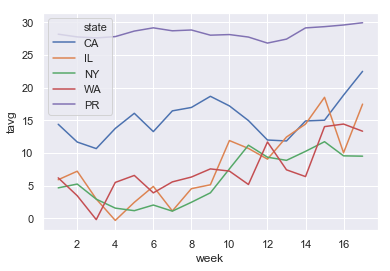

In [364]:
sns.lineplot(x="week", y="tavg", data=aggTempDf[aggTempDf["state"].isin(["NY", "WA", "IL", "CA", "PR"])], hue="state")

In [367]:
casesAllDf = caseIntDemoDf.merge(aggTempDf[["State_FIP", "week", "tavg"]], on=["week", "State_FIP"], how="left")
casesAllDf = casesAllDf.rename(columns={"tavg":"avg_temp_prev_week"})
casesAllDf.head()

,province_state,country_region,date,latitude,longitude,location_geom,confirmed,deaths,recovered,active,...,closing_of_public_venues,non-essential_services_closure,social_distancing,shelter_in_place,religious_gatherings_banned,lockdown,totalInt,week,flights_prev_week,avg_temp_prev_week
0,California,US,2020-02-21,NaN,NaN,None,1,0,0,NaN,...,0,0,0,0,0,0,0,7,774.0,16.449679
1,California,US,2020-02-22,NaN,NaN,None,1,0,0,NaN,...,0,0,0,0,0,0,0,7,774.0,16.449679
2,California,US,2020-02-23,NaN,NaN,None,1,0,0,NaN,...,0,0,0,0,0,0,0,7,774.0,16.449679
3,California,US,2020-02-24,NaN,NaN,None,1,0,0,NaN,...,0,0,0,0,0,0,0,8,854.0,16.969811
4,California,US,2020-02-25,NaN,NaN,None,1,0,0,NaN,...,0,0,0,0,0,0,0,8,854.0,16.969811


## Imputing missing temperature values using mean temperature that week

In [376]:
# casesAllDf[casesAllDf["avg_temp_prev_week"].isna()]
tempFillerDict = casesAllDf.groupby("week")["avg_temp_prev_week"].mean().to_dict()
casesAllDf["avg_temp_prev_week"] = casesAllDf[["week", "avg_temp_prev_week"]].apply(
    lambda x: tempFillerDict[x[0]] if pd.isnull(x[1]) else x[1], axis=1)
casesAllDf.sample(10)

,province_state,country_region,date,latitude,longitude,location_geom,confirmed,deaths,recovered,active,...,closing_of_public_venues,non-essential_services_closure,social_distancing,shelter_in_place,religious_gatherings_banned,lockdown,totalInt,week,flights_prev_week,avg_temp_prev_week
11809,Texas,US,2020-04-10,34.530289,-101.734917,POINT(-101.7349174 34.53028891),3,0,0,0.0,...,1,1,1,0,0,0,8,14,6.0,22.095986
16734,Kansas,US,2020-03-25,38.391849,-97.647699,POINT(-97.64769869 38.39184858),0,0,0,0.0,...,0,0,1,0,0,0,6,12,0.0,11.596440
6405,Idaho,US,2020-04-09,42.688913,-114.265503,POINT(-114.2655033 42.68891267),19,0,0,0.0,...,1,1,1,1,1,0,10,14,0.0,5.677900
18773,Alabama,US,2020-03-26,34.459469,-85.807829,POINT(-85.80782906 34.45946862),1,0,0,0.0,...,0,0,0,0,0,0,4,12,0.0,23.761816
85240,Ohio,US,2020-03-24,41.167935,-81.197358,POINT(-81.19735782 41.16793482),4,0,0,0.0,...,1,1,1,1,0,0,7,12,4.0,10.948315
37711,Illinois,US,2020-04-17,39.391335,-88.806111,POINT(-88.80611122 39.39133527),4,0,0,4.0,...,1,1,1,1,1,0,10,15,0.0,18.522765
19151,Alabama,US,2020-03-29,32.539527,-86.644082,POINT(-86.64408227 32.53952745),6,0,0,0.0,...,1,1,0,0,0,0,7,12,0.0,23.761816
5253,Ohio,US,2020-04-01,39.751072,-82.630882,POINT(-82.63088163 39.75107189),22,0,0,0.0,...,1,1,1,1,0,0,7,13,0.0,14.181970
12354,Texas,US,2020-04-19,31.948547,-98.558764,POINT(-98.55876441 31.94854689),4,0,0,4.0,...,1,1,1,0,0,0,8,15,0.0,26.636146
86244,Texas,US,2020-04-19,29.187574,-95.445632,POINT(-95.44563172 29.18757369),304,3,0,301.0,...,1,1,1,1,1,0,10,15,0.0,26.636146


In [379]:
caseIntDemoDf.columns

Index(['province_state', 'country_region', 'date', 'latitude', 'longitude',
       'location_geom', 'confirmed', 'deaths', 'recovered', 'active', 'fips',
       'admin2', 'combined_key', 'State_FIP', 'Urban', 'Population',
       'Frac65Plus', 'PopDensity', 'startDate', 'approxDays', 'casesPer1M',
       'fip_code', 'gathering_size_500_to_101', 'gathering_size_100_to_26',
       'gathering_size_25_to_11', 'gathering_size_10_0', 'school_closure',
       'closing_of_public_venues', 'non-essential_services_closure',
       'social_distancing', 'shelter_in_place', 'religious_gatherings_banned',
       'lockdown', 'totalInt', 'week', 'flights_prev_week'],
      dtype='object')

In [381]:
features = ['approxDays', 'Urban',
       'Frac65Plus', 'PopDensity', 'gathering_size_500_to_101', 'gathering_size_100_to_26',
       'gathering_size_25_to_11', 'gathering_size_10_0', 'school_closure',
       'closing_of_public_venues', 'non-essential_services_closure',
       'social_distancing', 'shelter_in_place', 'religious_gatherings_banned',
       'lockdown', 'flights_prev_week',
       'avg_temp_prev_week','casesPer1M']
featuresDf = casesAllDf[features]
featuresDf.head()

,approxDays,Urban,Frac65Plus,PopDensity,gathering_size_500_to_101,gathering_size_100_to_26,gathering_size_25_to_11,gathering_size_10_0,school_closure,closing_of_public_venues,non-essential_services_closure,social_distancing,shelter_in_place,religious_gatherings_banned,lockdown,flights_prev_week,avg_temp_prev_week,casesPer1M
0,11,5.0,0.178774,38.219686,0,0,0,0,0,0,0,0,0,0,0,774.0,16.449679,7.33283
1,12,5.0,0.178774,38.219686,0,0,0,0,0,0,0,0,0,0,0,774.0,16.449679,7.33283
2,13,5.0,0.178774,38.219686,0,0,0,0,0,0,0,0,0,0,0,774.0,16.449679,7.33283
3,14,5.0,0.178774,38.219686,0,0,0,0,0,0,0,0,0,0,0,854.0,16.969811,7.33283
4,15,5.0,0.178774,38.219686,0,0,0,0,0,0,0,0,0,0,0,854.0,16.969811,7.33283


In [382]:
featuresDf.to_csv("./data/us_covid19_features_apr25.csv", index=False)

In [383]:
caseIntDemoDf.to_csv("./data/raw_us_covid19_features_apr25.csv", index=False)